# Response to Step inputs

we feed the neuron with spikes drawn from an inhomogeneous Poisson process whose time-varying rate is set by step functions

In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter1d

import sys
from parallel import Parallel

sys.path.append('../..')
import plot_tools as pt
import matplotlib.pylab as plt
sys.path.append('../../analyz')
from analyz.processing.signanalysis import autocorrel, crosscorrel

# Run

### Basket Cell
```
    python step_stim.py --test_with_repeats -c Basket\
                        --with_presynaptic_spikes\
                        --stimFreq 10e-3\
                        --bgFreqInhFactor 1\
                        --iBranch 1 --nSpikeSeed 102
```
### Martinotti Cell
```
    python step_stim.py --test_with_repeats -c Martinotti\
                        --with_NMDA\
                        --with_presynaptic_spikes\
                        --stimFreq 4e-4\
                        --bgFreqInhFactor 1\
                        --iBranch 1 --nSpikeSeed 102
```

# Plot

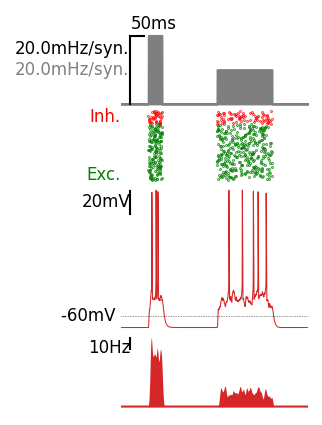

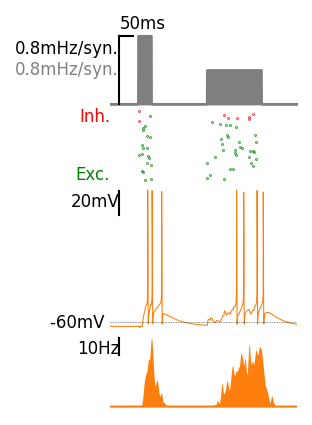

In [25]:
rate_smoothing = 3. # ms
zoom = [100,780]

RESULTS = {'Martinotti_example_index':50, # 33, 42, 49, 50
           'Basket_example_index':2} # 31

#for cellType in ['Martinotti', 'Basket', 'MartinottinoNMDA', 'BasketUniform']:
for cellType in ['Martinotti', 'Basket']:

    sim = Parallel(\
            filename='../../data/detailed_model/StepStim_demo_%s.zip' % cellType)
    sim.load()

    sim.fetch_quantity_on_grid('spikes', dtype=list)

    seeds = np.unique(sim.spikeSeed)
    
    dt = sim.fetch_quantity_on_grid('dt', return_last=True)
    tstop = sim.fetch_quantity_on_grid('tstop', return_last=True)

    spikes_matrix= np.zeros((len(seeds), int(tstop/dt)+1))
    RESULTS['%s_rate' % cellType] = []
    for i, spikes in enumerate(sim.spikes):
        spikes_matrix[i,(spikes/dt).astype('int')] = True
    RESULTS['rate_%s' % cellType] = 1e3*gaussian_filter1d(np.mean(spikes_matrix, axis=0)/dt,
                                                           int(rate_smoothing/dt))
    

    RESULTS['stimFreq_%s' % cellType] = sim.fetch_quantity_on_grid('stimFreq', return_last=True)
    RESULTS['bgFreqInhFactor_%s' % cellType] = sim.fetch_quantity_on_grid('bgFreqInhFactor', return_last=True)

    if '%s_example_index' % cellType in RESULTS:
        sim.fetch_quantity_on_grid('Stim', return_last=True, dtype=np.ndarray)
        RESULTS['Input_%s' % cellType] = sim.Stim[RESULTS['%s_example_index' % cellType]]
        sim.fetch_quantity_on_grid('Vm_soma', return_last=True, dtype=np.ndarray)
        RESULTS['Vm_%s' % cellType] = sim.Vm_soma[RESULTS['%s_example_index' % cellType]]
        sim.fetch_quantity_on_grid('presynaptic_exc_events', dtype=list)
        RESULTS['pre_exc_%s' % cellType] = sim.presynaptic_exc_events[RESULTS['%s_example_index' % cellType]]
        sim.fetch_quantity_on_grid('presynaptic_inh_events', dtype=list)
        RESULTS['pre_inh_%s' % cellType] = sim.presynaptic_inh_events[RESULTS['%s_example_index' % cellType]]
        
    RESULTS['t'] = np.arange(len(RESULTS['rate_%s' % cellType]))*dt
    RESULTS['dt'] = dt    


for cellType, color in zip(['Basket', 'Martinotti'], ['tab:red', 'tab:orange']):

    fig, AX = pt.figure(axes_extents=[[(1,1)],[(1,1)],[(1,2)],[(1,1)]],
                        figsize=(1.2,0.8), left=0, bottom=0., hspace=0.)

    # input
    AX[0].fill_between(RESULTS['t'][:-1][::20], 0*RESULTS['t'][:-1][::20], RESULTS['Input_%s' % cellType][::20],
                       color='tab:grey', lw=1)

    # Vm
    AX[2].plot(RESULTS['t'][::10], RESULTS['Vm_%s' % cellType][::10], color=color, lw=0.5)
    AX[2].plot(RESULTS['t'][::100], -60+0*RESULTS['t'][::100], 'k:', lw=0.3)

    # rate
    if RESULTS['rate_%s' % cellType] is not None:
        AX[3].fill_between(RESULTS['t'][::20], 0*RESULTS['t'][::20], RESULTS['rate_%s' % cellType][::20],
                           color=color, lw=0)
        AX[3].plot(RESULTS['t'][::20], 0*RESULTS['t'][::20], color=color, lw=1)
        
    # events
    if 'pre_inh_%s'%cellType in RESULTS:
        subsampling = 7 if cellType=='Basket' else 1
        # 1/4 for display
        for i, events in enumerate(RESULTS['pre_exc_%s' % cellType]):
            if len(events)>0:
                e = np.random.choice(events, np.min([int(len(events)/subsampling+1),1]), replace=False)
                AX[1].plot(e, i*np.ones(len(e)), 'o', fillstyle='full', color='g', ms=.3)
        for i, events in enumerate(RESULTS['pre_inh_%s' % cellType]):
            if len(events)>0:
                e = np.random.choice(events, np.min([int(len(events)/subsampling+1),1]), replace=False)
                AX[1].plot(e, len(RESULTS['pre_exc_%s' % cellType])+i*np.ones(len(e)), 'o', 
                           fillstyle='full', color='r', ms=.3)

    pt.set_common_xlims(AX, lims=zoom)
    
    pt.draw_bar_scales(AX[0], Xbar=50, Xbar_label='50ms', Ybar=2,
                       Ybar_label='%.1fmHz/syn.' % (2*1e3*RESULTS['stimFreq_%s' % cellType]),
                       Ybar_label2='%.1fmHz/syn.' % (2*1e3*RESULTS['stimFreq_%s' % cellType]*RESULTS['bgFreqInhFactor_%s' % cellType]))
    pt.annotate(AX[2], '-60mV ', (zoom[0],-60), xycoords='data', ha='right', va='center')
    pt.draw_bar_scales(AX[2], Xbar=1e-12, Ybar=20,Ybar_label='20mV')
    pt.annotate(AX[1], 'Inh.', (0,1), ha='right', va='top', color='r')
    pt.annotate(AX[1], 'Exc.', (0,0), ha='right', va='bottom', color='g')
    for ax in AX:
        ax.axis('off')
    pt.draw_bar_scales(AX[3], Xbar=1e-12, Ybar=10,Ybar_label='10Hz')
    fig.savefig('../../figures/detailed_model/StepSim_example_%s.svg' % cellType)

## Look for traces

In [ ]:
rate_smoothing = 3. # ms

for iN in range(50,70):
    RESULTS = {'Martinotti_example_index':iN, #7, 11 late spike
               'Basket_example_index':iN} # 5
    
    #for cellType in ['Martinotti', 'Basket', 'MartinottinoNMDA', 'BasketUniform']:
    for cellType in ['Martinotti', 'Basket']:
    
        sim = Parallel(\
                filename='../../data/detailed_model/StepStim_demo_%s.zip' % cellType)
        sim.load()
    
        sim.fetch_quantity_on_grid('spikes', dtype=list)
    
        seeds = np.unique(sim.spikeSeed)
        
        dt = sim.fetch_quantity_on_grid('dt', return_last=True)
        tstop = sim.fetch_quantity_on_grid('tstop', return_last=True)
    
        spikes_matrix= np.zeros((len(seeds), int(tstop/dt)+1))
        RESULTS['%s_rate' % cellType] = []
        for i, spikes in enumerate(sim.spikes):
            spikes_matrix[i,(spikes/dt).astype('int')] = True
        RESULTS['rate_%s' % cellType] = 1e3*gaussian_filter1d(np.mean(spikes_matrix, axis=0)/dt,
                                                               int(rate_smoothing/dt))
        
    
        RESULTS['stimFreq_%s' % cellType] = sim.fetch_quantity_on_grid('stimFreq', return_last=True)
        RESULTS['bgFreqInhFactor_%s' % cellType] = sim.fetch_quantity_on_grid('bgFreqInhFactor', return_last=True)
    
        if '%s_example_index' % cellType in RESULTS:
            sim.fetch_quantity_on_grid('Stim', return_last=True, dtype=np.ndarray)
            RESULTS['Input_%s' % cellType] = sim.Stim[RESULTS['%s_example_index' % cellType]]
            sim.fetch_quantity_on_grid('Vm_soma', return_last=True, dtype=np.ndarray)
            RESULTS['Vm_%s' % cellType] = sim.Vm_soma[RESULTS['%s_example_index' % cellType]]
            sim.fetch_quantity_on_grid('presynaptic_exc_events', dtype=list)
            RESULTS['pre_exc_%s' % cellType] = sim.presynaptic_exc_events[RESULTS['%s_example_index' % cellType]]
            sim.fetch_quantity_on_grid('presynaptic_inh_events', dtype=list)
            RESULTS['pre_inh_%s' % cellType] = sim.presynaptic_inh_events[RESULTS['%s_example_index' % cellType]]
            
        RESULTS['t'] = np.arange(len(RESULTS['rate_%s' % cellType]))*dt
        RESULTS['dt'] = dt    
    
    zoom = [100, RESULTS['t'][-1]]
    
    for cellType, color in zip(['Basket', 'Martinotti'], ['tab:red', 'tab:orange']):

        fig, AX = pt.figure(axes_extents=[[(1,1)],[(1,1)],[(1,2)],[(1,1)]],
                            figsize=(1.3,0.8), left=0, bottom=0., hspace=0.)
        fig.suptitle('i0=%i' % iN)
    
        # input
        AX[0].fill_between(RESULTS['t'][:-1][::20], 0*RESULTS['t'][:-1][::20], RESULTS['Input_%s' % cellType][::20],
                           color='tab:grey', lw=1)
    
        # Vm
        AX[2].plot(RESULTS['t'][::10], RESULTS['Vm_%s' % cellType][::10], color=color, lw=0.5)
        AX[2].plot(RESULTS['t'][::100], -60+0*RESULTS['t'][::100], 'k:', lw=0.3)
    
        # rate
        if RESULTS['rate_%s' % cellType] is not None:
            AX[3].fill_between(RESULTS['t'][::20], 0*RESULTS['t'][::20], RESULTS['rate_%s' % cellType][::20],
                               color=color, lw=1)
            
        # events
        if 'pre_inh_%s'%cellType in RESULTS:
            subsampling = 10 if cellType=='Basket' else 1
            # 1/4 for display
            for i, events in enumerate(RESULTS['pre_exc_%s' % cellType]):
                if len(events)>0:
                    e = np.random.choice(events, np.min([int(len(events)/subsampling+1),1]), replace=False)
                    AX[1].plot(e, i*np.ones(len(e)), 'o', fillstyle='full', color='g', ms=.3)
            for i, events in enumerate(RESULTS['pre_inh_%s' % cellType]):
                if len(events)>0:
                    e = np.random.choice(events, np.min([int(len(events)/subsampling+1),1]), replace=False)
                    AX[1].plot(e, len(RESULTS['pre_exc_%s' % cellType])+i*np.ones(len(e)), 'o', 
                               fillstyle='full', color='r', ms=.3)
    
        pt.set_common_xlims(AX, lims=zoom)
        
        pt.draw_bar_scales(AX[0], Xbar=50, Xbar_label='50ms', Ybar=2,
                           Ybar_label='%.1fmHz/syn.' % (2*1e3*RESULTS['stimFreq_%s' % cellType]),
                           Ybar_label2='%.1fmHz/syn.' % (2*1e3*RESULTS['stimFreq_%s' % cellType]*RESULTS['bgFreqInhFactor_%s' % cellType]))
        pt.annotate(AX[2], '-60mV ', (zoom[0],-60), xycoords='data', ha='right', va='center')
        pt.draw_bar_scales(AX[2], Xbar=1e-12, Ybar=20,Ybar_label='20mV')
        pt.annotate(AX[1], 'Inh.', (0,1), ha='right', va='top', color='r')
        pt.annotate(AX[1], 'Exc.', (0,0), ha='right', va='bottom', color='g')
        for ax in AX:
            ax.axis('off')
        pt.draw_bar_scales(AX[3], Xbar=1e-12, Ybar=10,Ybar_label='10Hz')
        #fig.savefig('../../figures/detailed_model/StepSim_example_%s.svg' % cellType)